In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Grid Method

We're actually going to describe the Grid Method first rather than the Exact Method to underscore that this is all just Bayes Rule applied to models (hypotheses, theories, etc) based on data (evidence, observations, etc).

We start out with an article that appeared in *The Guardian* on Friday, January 4, 2002:

"When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110. 'It looks very suspicious to me,' said Barry Blight, a statistics lecturer at the London School of Economics. 'If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.'

Let us ignore the final statement for the moment and concentrate on the actual problem.

Looking at Bayes Rule,

$$P(\theta|D) = \frac{P(D|\theta)P(\theta)}{P(D)}$$

our *general* process is going to be:

1. Enumerate the possible hypotheses/models.
2. Assign prior probabilities.
3. Collect data and calculate likelihoods.
4. Combine priors and likelihoods to calculate posterior probabilities.

## Enumerate Models

If $\theta$ is our set of models, we know all the values that $\theta$ could *possibly* take are between $[0.0, 1.0]$ even before we flip the coin. To us, each possible value of $\theta$ is a *model*. Additionally, the possible realization of any of these models is just an event and therefore we can describe our certainty in each of the models with a probability and thus our certainty over all of the models collectively with a probability distribution. What is the probability of $P(\theta=0.5)$? $P(\theta=0.51)$?

Looking at every possible real numbered value of $\theta$ would be a bit exhausting so let's agree that there's not much difference in $\theta=0.53$ and $\theta=0.54$. This is the heart of the Grid method. With this simplification, we can concern ourselves with a limited set of possible $\theta$ values, say, increments of $0.05$ from $[0.0, 1.0]$. This is our enumeration of the possible models (or hypotheses if you like).

In code,

In [3]:
thetas = [i * 0.05 for i in range( 0, 21)]
print(thetas)

[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0]


And here we see the warts of representing real numbers in computers.

## Prior Probabilities

Given these values of $\theta$, what prior probabilities should we assign to them? Is it very unlikely that the value of $\theta=0.0$...I mean it *could* happen What about $\theta=1.0$? Also unlikely...although the coin could be a gag coin from a magic shop or the Belgians could be playing a trick on us. So we shouldn't rule them out. This is known as [*Cromwell's Rule*](https://en.wikipedia.org/wiki/Cromwell%27s_rule),

> I pray beseech you in the bowels of Christ, please consider that you might be wrong.

Don't ask.

The *prior* probability distribution for $\theta$, $P(\theta)$, should encode this knowledge. In general, the only requirement is that we not rule out anything that is possible no matter how improbable. We can just assign a very low probability to unlikely models.

So what kind of prior do we want? We generally believe coins are fair unless we have some reason to believe they're not (they look suspicious and may have come from a magic shop, perhaps because they have The Riddler as the "heads"). But if someone pulls out a random Euro from their pocket, we tend to think, "oh, a fair coin" even if "fair" is a somewhat fuzzy notion.

Let's use a triangle shaped distribution as our prior where most of the probability will be around $\theta=0.5$ and the rest will taper off towards $\theta=0.0$ and $\theta=1.0$.

In [4]:
priors = [11 - abs( 10 - i) for i in range( 0, 21)]
normalizer = sum( priors)
priors = [ x / normalizer for x in priors]
print( "theta\tprob()")
for t, p in zip( thetas, priors):
    print( "%.2f\t%.2f" % (t, p))

theta	prob()
0.00	0.01
0.05	0.02
0.10	0.02
0.15	0.03
0.20	0.04
0.25	0.05
0.30	0.06
0.35	0.07
0.40	0.07
0.45	0.08
0.50	0.09
0.55	0.08
0.60	0.07
0.65	0.07
0.70	0.06
0.75	0.05
0.80	0.04
0.85	0.03
0.90	0.02
0.95	0.02
1.00	0.01


One of the most confusing things about this is that it looks like we're assigning probabilities to probabilities. Don't think about it this way. $\theta$ is a set of models for a parameter $p$ of a coin flip, described as a Bernoulli process. Each parameter has a priror probability of being true (second column).

Here's a function to help us plot these probability distributions:

In [5]:
def probability_plot( axes, xs, ys, color):
    n = len( xs)
    margin = 0.05 * max( xs)
    min_x, max_x = min( xs) - margin, max( xs) + margin
    min_y, max_y = 0.0, max( ys) * 1.1

    axes.vlines( xs, [0.0] * n, ys, color=color, linewidth=5)
    axes.set_xlim( [ min_x, max_x])
    axes.set_ylim( [ 0.0, 1.0])
    
    return axes

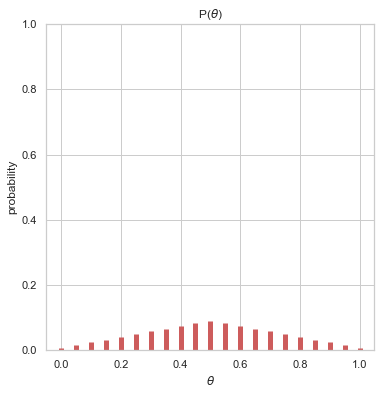

In [6]:
figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)

axes = probability_plot( axes, thetas, priors, "indianred")

axes.set_title( r"P($\theta$)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

plt.show()
plt.close()

## Data

Next, we have some data, $D=\{H: 140, T:110\}$ and we want to know how this data should change our *prior* probability distribution over $\theta$, our certainty in each mode (value of $\theta$). We do this through the likelihood, $P(D|\theta)$.

The likehood is the probability of the data given the model. Since the data is fixed, what we're really going to do is go through and calculate the probability of the data for each possible value of $\theta$ we're interested in. In this particular case, we need to calculate the probability of 140 heads and 110 tails for each of our $\theta$s. We can do this with the Binomial Distribution:

$$X \sim B(k; n, p) = \binom{n}{k}p^k(1-p)^{n-k}$$

Let's change this to match our problem by turning $p$ into $\theta$:

$$X \sim B(k; n, \theta) = \binom{n}{k}\theta^k(1-\theta)^{n-k}$$

except that we will keep $k$ and $n$ constant (we know these values) and vary $\theta$. Basically, for each value of $\theta$ in our grid, what was the probability of seeing the data, $P(D|\theta)$?

In [7]:
likelihoods = [stats.binom.pmf( 140, 250, t) for t in thetas]
normalizer = sum( likelihoods) # because we're not doing the continuous case
likelihoods = [ lh / normalizer for lh in likelihoods]
print("theta\tP(d|theta)")
for t, lh in zip( thetas, likelihoods):
    print("%.2f\t%.4e" %( t, lh))

theta	P(d|theta)
0.00	0.0000e+00
0.05	4.8260e-111
0.10	1.7574e-71
0.15	1.4691e-49
0.20	5.7848e-35
0.25	1.7641e-24
0.30	1.0863e-16
0.35	7.3822e-11
0.40	1.4562e-06
0.45	1.4718e-03
0.50	1.0488e-01
0.55	6.0582e-01
0.60	2.7923e-01
0.65	8.5812e-03
0.70	1.1892e-05
0.75	3.6322e-10
0.80	6.6694e-17
0.85	5.8463e-27
0.90	7.4498e-43
0.95	1.1122e-72
1.00	0.0000e+00


It is not strictly necessary to normalize the likelihoods because the constant drops out when we normalize at the end. However, it does permit us to demonstrate the differences in the strengths of the prior distribution and the likelihood.

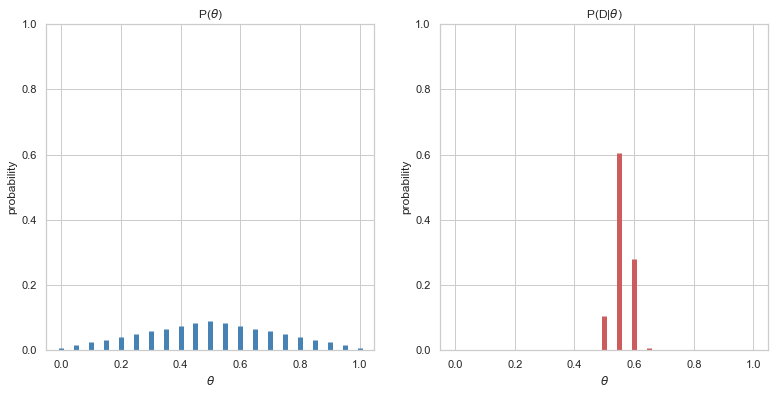

In [8]:
figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)

axes = probability_plot( axes, thetas, priors, "steelblue")
axes.set_title( r"P($\theta$)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

axes = figure.add_subplot(1, 3, 2)

axes = probability_plot( axes, thetas, likelihoods, "indianred")
axes.set_title( r"P(D|$\theta$)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

plt.show()
plt.close()

Relative to our prior, the likelhood is quite striking. While our prior suggests that we consider possible values of $\theta$ around 0.2 or 0.8, the likehood is quite different and concentrated around 0.5.

## Posterior

At this point, the problem is not any different than we saw in the Applied Probability section of the Probability chapter. We are essentially multiplying the prior and likelihood for each value of $\theta$ as if it were the Elvis or M&M problems. We then normalize:

In [9]:
posteriors = [ p * lh for p, lh in zip(priors, likelihoods)]
normalizer = sum( posteriors)
posteriors = [ p / normalizer for p in posteriors]
print("theta\tP(theta|data)")
for t, p in zip( thetas, posteriors):
    print("%.2f\t%.4e" %( t, p))

theta	P(theta|data)
0.00	0.0000e+00
0.05	9.8405e-112
0.10	5.3751e-72
0.15	5.9911e-50
0.20	2.9489e-35
0.25	1.0792e-24
0.30	7.7526e-17
0.35	6.0211e-11
0.40	1.3362e-06
0.45	1.5005e-03
0.50	1.1762e-01
0.55	6.1765e-01
0.60	2.5622e-01
0.65	6.9990e-03
0.70	8.4870e-06
0.75	2.2219e-10
0.80	3.3998e-17
0.85	2.3842e-27
0.90	2.2786e-43
0.95	2.2679e-73
1.00	0.0000e+00


And now we can plot all three to see how our prior certainty surrounding the model and the data combine to revise our understanding:

Text(0, 0.5, 'probability')

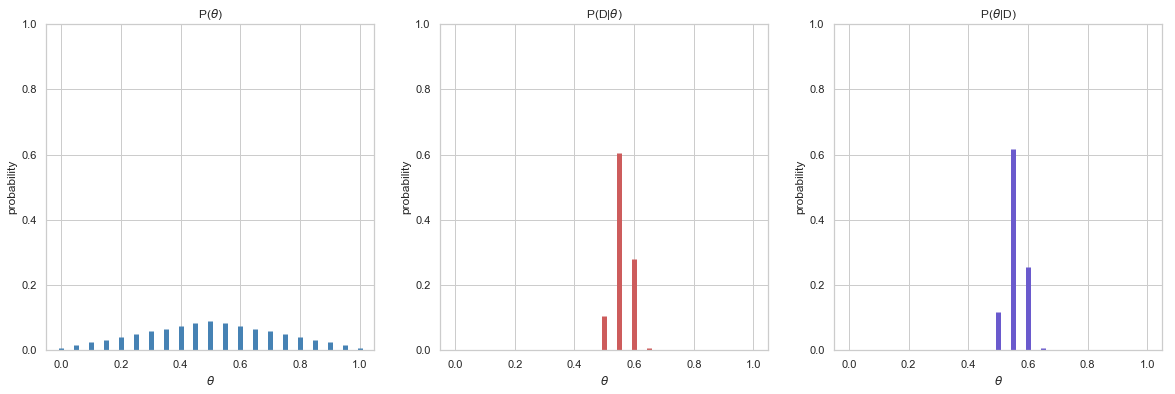

In [10]:
figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)

axes = probability_plot( axes, thetas, priors, "steelblue")
axes.set_title( r"P($\theta$)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

axes = figure.add_subplot(1, 3, 2)

axes = probability_plot( axes, thetas, likelihoods, "indianred")
axes.set_title( r"P(D|$\theta$)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

axes = figure.add_subplot(1, 3, 3)

axes = probability_plot( axes, thetas, posteriors, "slateblue")
axes.set_title( r"P($\theta$|D)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

We can see here that the evidence was quite strong in the face of our prior uncertainty. Over the course of this chapter and text, we'll talk about a variety of ways to use the posterior distribution but one way is to set some kind of *Region of Practical Equivalence* (ROPE) and determine what the probability of that region is.

For example, we might decide that from $\theta=0.45$ to $\theta=0.55$ is approximately a fair coin. If we look at our posterior distribution for that, we have:

| $\theta$ | $P(\theta|D)$ |
|:------:|:-----------:|
| 0.45 | 0.00150051051059 |
| 0.50 | 0.117621046234 |
| 0.55 | 0.617652656199 |

which totals to 73.68%, which may or may not be decisive for our purposes.

### Priors and Model Checking

One thing you might be asking yourself is, why do we even need priors? This is a good question. Sometimes priors are obvious. For example, the coin came from a magic shop and was supposed to be a trick coin with heads coming up 25% of the time. Other times, you have the results of previous experiments or perhaps engineering or analtyical results that suggest a value.

And other times, you have no bloody idea whatsoever and all you want to do is not rule anything out (so-called *non-informative* priors which are often--but not always--from a Uniform distribution).

In the case that you have *informative* priors, you definitely want to see if the priors make a difference in your results. If they do, then the priors need justification. However, we will see that sometimes the priors just don't matter at all because there's so much data. This is known as "the tendency for the data to swamp the priors".

Let's see if any of these cases make a difference.

**Case 1: A stronger certainty in an unbiased coin.**

In this case, we're going to re-run everything we just did but with a prior that emphasizes $\theta$s around 0.5 more strongly.

theta	P(theta)
0.00	0.01
0.05	0.01
0.10	0.01
0.15	0.01
0.20	0.01
0.25	0.01
0.30	0.01
0.35	0.01
0.40	0.01
0.45	0.22
0.50	0.45
0.55	0.22
0.60	0.01
0.65	0.01
0.70	0.01
0.75	0.01
0.80	0.01
0.85	0.01
0.90	0.01
0.95	0.01
1.00	0.01
------
theta	P(theta|data)
0.00	0.0000e+00
0.05	1.4638e-112
0.10	5.3303e-73
0.15	4.4559e-51
0.20	1.7546e-36
0.25	5.3507e-26
0.30	3.2948e-18
0.35	2.2391e-12
0.40	4.4168e-08
0.45	1.7856e-03
0.50	2.5449e-01
0.55	7.3500e-01
0.60	8.4693e-03
0.65	2.6027e-04
0.70	3.6069e-07
0.75	1.1017e-11
0.80	2.0229e-18
0.85	1.7732e-28
0.90	2.2596e-44
0.95	3.3735e-74
1.00	0.0000e+00


Text(0, 0.5, 'probability')

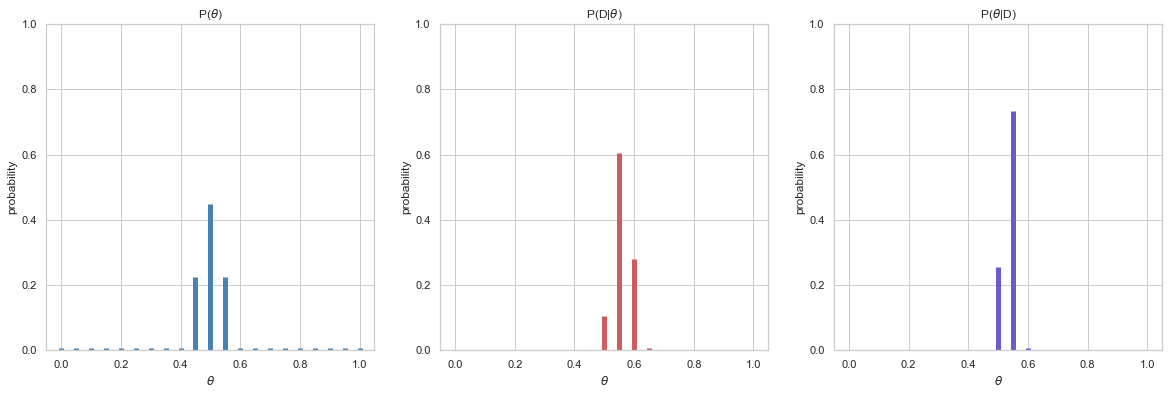

In [11]:
# prior
priors = [0.25 for i in range( 0, 21)]
priors[  9] = 10
priors[ 10] = 20
priors[ 11] = 10
normalizer = sum( priors)
priors = [ x / normalizer for x in priors]
print( "theta\tP(theta)")
for t, p in zip( thetas, priors):
    print( "%.2f\t%.2f" % (t, p))

# posterior
posteriors = [ p * lh for p, lh in zip(priors, likelihoods)]
normalizer = sum( posteriors)
posteriors = [ p / normalizer for p in posteriors]
print("------")
print("theta\tP(theta|data)")
for t, p in zip( thetas, posteriors):
    print("%.2f\t%.4e" %( t, p))
figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)

axes = probability_plot( axes, thetas, priors, "steelblue")
axes.set_title( r"P($\theta$)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

axes = figure.add_subplot(1, 3, 2)

axes = probability_plot( axes, thetas, likelihoods, "indianred")
axes.set_title( r"P(D|$\theta$)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

axes = figure.add_subplot(1, 3, 3)

axes = probability_plot( axes, thetas, posteriors, "slateblue")
axes.set_title( r"P($\theta$|D)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

The results this time are quite striking. We have a strong prior probability for $\theta=0.5$ with slightly weaker probabilities for both 0.45 and 0.55. However, when we combine this with the evidence, the probability of $\theta=0.55$ skyrockets.

Still there isn't anything hugely amiss here. With a ROPE of $(0.45, 0.55)$, we still have 98% probability instead of 73%. What if our mental model is just completely different?

**Case 2: A biased magic shop coin.**

What if we were told that our coin was from a magic shop and meant to show tails 75% of the time?

theta	P(theta)
0.00	0.01
0.05	0.01
0.10	0.01
0.15	0.01
0.20	0.22
0.25	0.45
0.30	0.22
0.35	0.01
0.40	0.01
0.45	0.01
0.50	0.01
0.55	0.01
0.60	0.01
0.65	0.01
0.70	0.01
0.75	0.01
0.80	0.01
0.85	0.01
0.90	0.01
0.95	0.01
1.00	0.01
------
theta	P(theta|data)
0.00	0.0000e+00
0.05	4.8260e-111
0.10	1.7574e-71
0.15	1.4691e-49
0.20	2.3139e-33
0.25	1.4113e-22
0.30	4.3452e-15
0.35	7.3822e-11
0.40	1.4562e-06
0.45	1.4718e-03
0.50	1.0488e-01
0.55	6.0582e-01
0.60	2.7923e-01
0.65	8.5812e-03
0.70	1.1892e-05
0.75	3.6322e-10
0.80	6.6694e-17
0.85	5.8463e-27
0.90	7.4498e-43
0.95	1.1122e-72
1.00	0.0000e+00


Text(0, 0.5, 'probability')

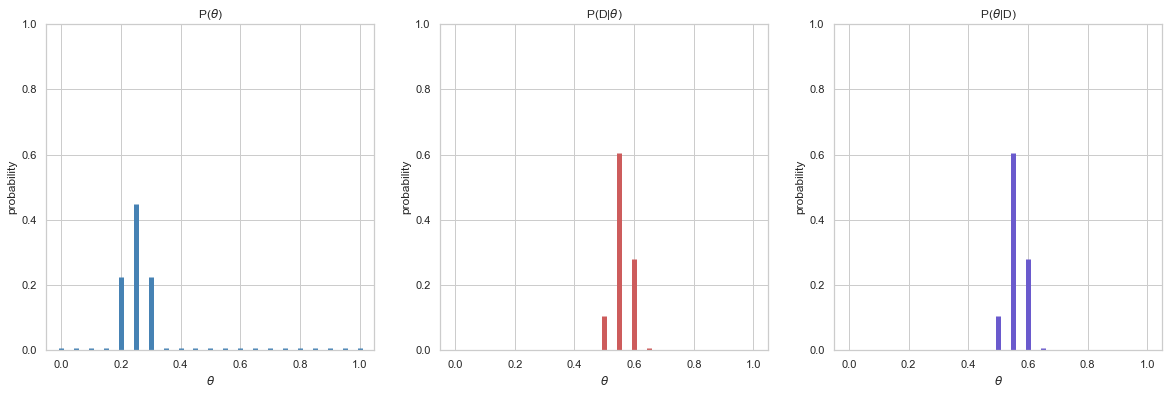

In [12]:
# prior
priors = [0.25 for i in range( 0, 21)]
priors[ 4] = 10
priors[ 5] = 20
priors[ 6] = 10
normalizer = sum( priors)
priors = [ x / normalizer for x in priors]
print( "theta\tP(theta)")
for t, p in zip( thetas, priors):
    print( "%.2f\t%.2f" % (t, p))

# posterior
posteriors = [ p * lh for p, lh in zip(priors, likelihoods)]
normalizer = sum( posteriors)
posteriors = [ p / normalizer for p in posteriors]
print("------")
print("theta\tP(theta|data)")
for t, p in zip( thetas, posteriors):
    print("%.2f\t%.4e" %( t, p))
figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)

axes = probability_plot( axes, thetas, priors, "steelblue")
axes.set_title( r"P($\theta$)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

axes = figure.add_subplot(1, 3, 2)

axes = probability_plot( axes, thetas, likelihoods, "indianred")
axes.set_title( r"P(D|$\theta$)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

axes = figure.add_subplot(1, 3, 3)

axes = probability_plot( axes, thetas, posteriors, "slateblue")
axes.set_title( r"P($\theta$|D)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

Despite our prior probability of $P(\theta = 0.25) = 0.45$, in the face of the evidence, the probability is 0.15%. This is good. This is exactly how we want this to work. If your prior certainty and the evidence are supporting, we should see a higher posterior certainty. If your prior certainty and the evidence are in conflict, we should see a lower certainty.

There are times when we just don't have any information about a process that gives us a good prior. In that case, we can use *uninformative* priors. In most cases (but not all) these are priors from the Uniform distribution:

**Case 3 - Uninformative Priors**

theta	P(theta)
0.00	0.05
0.05	0.05
0.10	0.05
0.15	0.05
0.20	0.05
0.25	0.05
0.30	0.05
0.35	0.05
0.40	0.05
0.45	0.05
0.50	0.05
0.55	0.05
0.60	0.05
0.65	0.05
0.70	0.05
0.75	0.05
0.80	0.05
0.85	0.05
0.90	0.05
0.95	0.05
1.00	0.05
------
theta	P(theta|data)
0.00	0.0000e+00
0.05	4.8260e-111
0.10	1.7574e-71
0.15	1.4691e-49
0.20	5.7848e-35
0.25	1.7641e-24
0.30	1.0863e-16
0.35	7.3822e-11
0.40	1.4562e-06
0.45	1.4718e-03
0.50	1.0488e-01
0.55	6.0582e-01
0.60	2.7923e-01
0.65	8.5812e-03
0.70	1.1892e-05
0.75	3.6322e-10
0.80	6.6694e-17
0.85	5.8463e-27
0.90	7.4498e-43
0.95	1.1122e-72
1.00	0.0000e+00


Text(0, 0.5, 'probability')

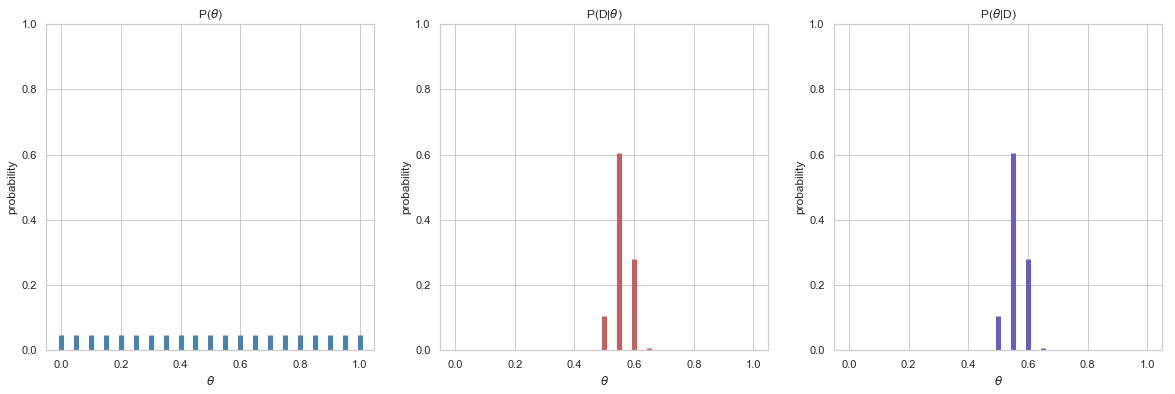

In [13]:
# prior
priors = [1 for i in range( 0, 21)]
normalizer = sum( priors)
priors = [ x / normalizer for x in priors]
print( "theta\tP(theta)")
for t, p in zip( thetas, priors):
    print( "%.2f\t%.2f" % (t, p))

# posterior
posteriors = [ p * lh for p, lh in zip(priors, likelihoods)]
normalizer = sum( posteriors)
posteriors = [ p / normalizer for p in posteriors]
print("------")
print("theta\tP(theta|data)")
for t, p in zip( thetas, posteriors):
    print("%.2f\t%.4e" %( t, p))
figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)

axes = probability_plot( axes, thetas, priors, "steelblue")
axes.set_title( r"P($\theta$)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

axes = figure.add_subplot(1, 3, 2)

axes = probability_plot( axes, thetas, likelihoods, "indianred")
axes.set_title( r"P(D|$\theta$)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

axes = figure.add_subplot(1, 3, 3)

axes = probability_plot( axes, thetas, posteriors, "slateblue")
axes.set_title( r"P($\theta$|D)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

Notice that in this case, the posterior is essentially the likelihood. Keep this in mind.

## More Data

We can better understand the origin of priors and the role of data if we consider the possibility of getting more data. Let's repeat the original results:

theta	prob()
0.00	0.01
0.05	0.02
0.10	0.02
0.15	0.03
0.20	0.04
0.25	0.05
0.30	0.06
0.35	0.07
0.40	0.07
0.45	0.08
0.50	0.09
0.55	0.08
0.60	0.07
0.65	0.07
0.70	0.06
0.75	0.05
0.80	0.04
0.85	0.03
0.90	0.02
0.95	0.02
1.00	0.01
------
theta	P(theta|data)
0.00	0.0000e+00
0.05	9.8405e-112
0.10	5.3751e-72
0.15	5.9911e-50
0.20	2.9489e-35
0.25	1.0792e-24
0.30	7.7526e-17
0.35	6.0211e-11
0.40	1.3362e-06
0.45	1.5005e-03
0.50	1.1762e-01
0.55	6.1765e-01
0.60	2.5622e-01
0.65	6.9990e-03
0.70	8.4870e-06
0.75	2.2219e-10
0.80	3.3998e-17
0.85	2.3842e-27
0.90	2.2786e-43
0.95	2.2679e-73
1.00	0.0000e+00


Text(0, 0.5, 'probability')

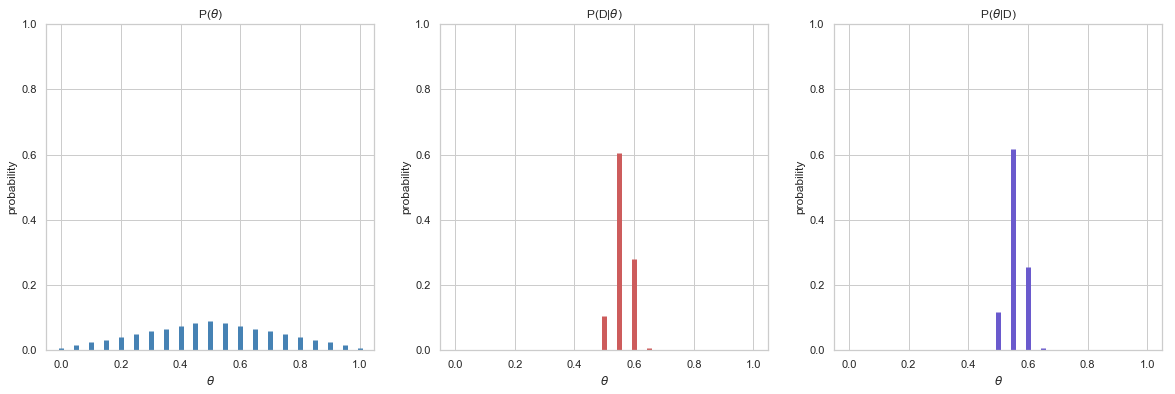

In [14]:
# prior
priors = [11 - abs( 10 - i) for i in range( 0, 21)]
normalizer = sum( priors)
priors = [ x / normalizer for x in priors]
print( "theta\tprob()")
for t, p in zip( thetas, priors):
    print( "%.2f\t%.2f" % (t, p))

# posterior
posteriors = [ p * lh for p, lh in zip(priors, likelihoods)]
normalizer = sum( posteriors)
posteriors = [ p / normalizer for p in posteriors]
print("------")
print("theta\tP(theta|data)")
for t, p in zip( thetas, posteriors):
    print("%.2f\t%.4e" %( t, p))
figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)

axes = probability_plot( axes, thetas, priors, "steelblue")
axes.set_title( r"P($\theta$)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

axes = figure.add_subplot(1, 3, 2)

axes = probability_plot( axes, thetas, likelihoods, "indianred")
axes.set_title( r"P(D|$\theta$)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

axes = figure.add_subplot(1, 3, 3)

axes = probability_plot( axes, thetas, posteriors, "slateblue")
axes.set_title( r"P($\theta$|D)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

Now suppose that we get more data, specifically, we flip the coin 250 more times and get 152 heads. There are two ways to handle this. First, we can simply start with our original prior and *pool* the data to calculate the likelihood and posterior or we can use our previous posterior as a prior, calculate the likelihood with only the new data, and calculate a new posterior. Since you prior may come from somewhere else (a paper, report, etc) that you don't have the raw data for, we'll show the second approach.

Using the posterior probabilities we just calculated as our new priors, we get the following results:

theta	prob()
0.00	0.00
0.05	0.00
0.10	0.00
0.15	0.00
0.20	0.00
0.25	0.00
0.30	0.00
0.35	0.00
0.40	0.00
0.45	0.00
0.50	0.12
0.55	0.62
0.60	0.26
0.65	0.01
0.70	0.00
0.75	0.00
0.80	0.00
0.85	0.00
0.90	0.00
0.95	0.00
1.00	0.00
------
theta	P(theta|data)
0.00	0.0000e+00
0.05	1.5830e-238
0.10	2.4676e-155
0.15	5.9232e-109
0.20	7.5017e-78
0.25	2.6430e-55
0.30	2.3857e-38
0.35	1.9483e-25
0.40	1.1065e-15
0.45	1.4662e-08
0.50	9.1014e-04
0.55	3.0678e-01
0.60	6.8486e-01
0.65	7.4586e-03
0.70	1.9394e-07
0.75	3.1643e-15
0.80	2.8067e-27
0.85	1.1274e-45
0.90	3.5371e-75
0.95	4.1190e-131
1.00	0.0000e+00


Text(0, 0.5, 'probability')

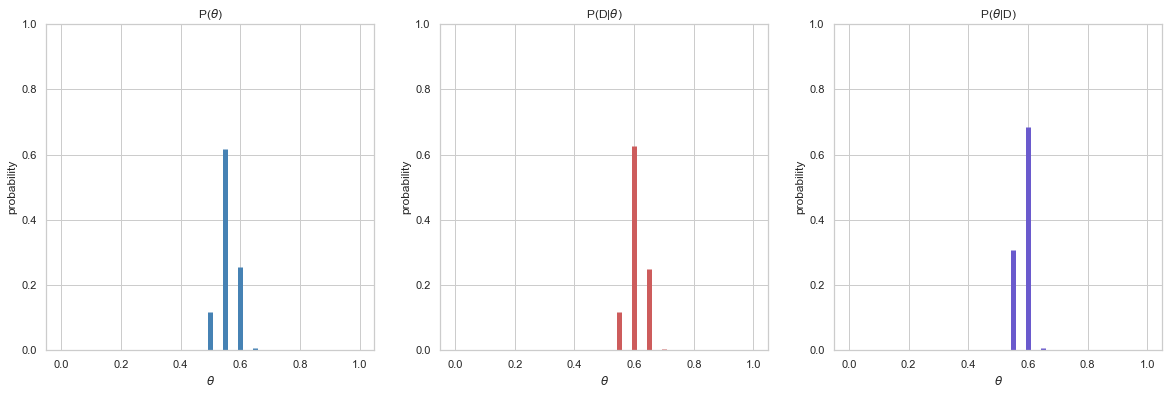

In [15]:
from copy import deepcopy

# prior is previous posterior, already normalized.
priors = deepcopy( posteriors)
print( "theta\tprob()")
for t, p in zip( thetas, priors):
    print( "%.2f\t%.2f" % (t, p))

# new likelihoods based on new data.
likelihoods = [stats.binom.pmf( 152, 250, t) for t in thetas]
normalizer = sum( likelihoods) # because we're not doing the continuous case
likelihoods = [ lh / normalizer for lh in likelihoods]

# posterior
posteriors = [ p * lh for p, lh in zip(priors, likelihoods)]
normalizer = sum( posteriors)
posteriors = [ p / normalizer for p in posteriors]
print("------")
print("theta\tP(theta|data)")
for t, p in zip( thetas, posteriors):
    print("%.2f\t%.4e" %( t, p))
figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)

axes = probability_plot( axes, thetas, priors, "steelblue")
axes.set_title( r"P($\theta$)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

axes = figure.add_subplot(1, 3, 2)

axes = probability_plot( axes, thetas, likelihoods, "indianred")
axes.set_title( r"P(D|$\theta$)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

axes = figure.add_subplot(1, 3, 3)

axes = probability_plot( axes, thetas, posteriors, "slateblue")
axes.set_title( r"P($\theta$|D)")
axes.set_xlabel( r"$\theta$")
axes.set_ylabel( "probability")

At about 66% for $P(\theta=0.6|D)$, it's getting more difficult to believe the coin is fair...

The Grid Method is a great way to try and understand the basic concepts of Bayesian inference. It shows explicitly how Bayes Rule is used and the roles of priors, likelihoods and how to interpret the prior.